D-213 ADVANCED DATA ANALYTICS  
TASK 1: TIME SERIES MODELING

PAOLA WILLIAMS
COLLEGE OF IT, WESTERN GOVERNOR’S UNIVERSITY
MAY 5th, 2023

A1. Research question

What is the revenue forecast for the first 6 months after the actual data?

A2. Objectives and goals

Create a predictive model to forecast future revenue by analizing the revenue per day for the last 2 years.

Identify the time series components of the dataset to understand how the revenue changes over time.

B. Summary of assumptions

Time series must be stationary, i.e, its statistical properties like mean and standard deviation do not change over time (2021, Pandian). Also, the autocorrelation, i.e, the correlation between a time series and a lagged version of itself over subsequent time intervals, is constant over time (Lendave, 2022).

The residuals are random and do not correlate.

There is no presence of outliers in the time series (Statistics Solutions,2021)

In [1]:
%pip install pmdarima
%pip install test_stationarity

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement test_stationarity (from versions: none)
ERROR: No matching distribution found for test_stationarity

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import signal
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
df = pd.read_csv(r'C:\Users\paowm\Downloads\teleco_time_series .csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [5]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


C1. Line graph visualization

Text(0.5, 1.0, 'Revenue per day in millions of $')

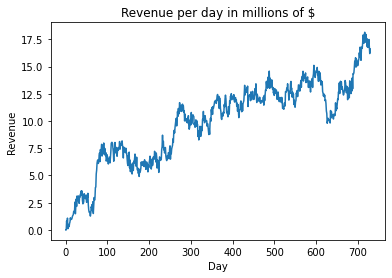

In [6]:
plt.plot(df['Revenue'])
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.title('Revenue per day in millions of $')

In [7]:
nulls = df.isnull().sum()
nulls

Day        0
Revenue    0
dtype: int64

In [8]:
dup = df.duplicated()
dup.value_counts()

False    731
dtype: int64

C2. Time step formatting

To covert the dataset into a time series, we must check for any gaps in the measurements. We can conform with the code above that the dataset consist of 731 days (2 years) with their corresponding values.

In [9]:
df = df[['Day','Revenue']]
df['Date'] = pd.date_range(start = pd.datetime(2019,1,1), periods=df.shape[0], freq='24H')
df.set_index('Date')
df = df[['Date','Revenue']]
df

C:\Users\paowm\AppData\Local\Temp/ipykernel_9812/1571984575.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['Date'] = pd.date_range(start = pd.datetime(2019,1,1), periods=df.shape[0], freq='24H')


,Date,Revenue
0,2019-01-01,0.000000
1,2019-01-02,0.000793
2,2019-01-03,0.825542
3,2019-01-04,0.320332
4,2019-01-05,1.082554
...,...,...
726,2020-12-27,16.931559
727,2020-12-28,17.490666
728,2020-12-29,16.803638
729,2020-12-30,16.194813


C3. Stationarity

In [10]:
df_test = adfuller(df['Revenue'], autolag='AIC')
df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# lags used','# of observations'])

for key,value in df_test[4].items():
    df_output['Critical// Value(%s)'%key] = value

print(df_output)

Test Statistic            -1.924612
p-value                    0.320573
# lags used                1.000000
# of observations        729.000000
Critical// Value(1%)      -3.439352
Critical// Value(5%)      -2.865513
Critical// Value(10%)     -2.568886
dtype: float64


In [11]:
diff = df.Revenue - df.Revenue.shift(1)
diff = diff.dropna(inplace = False)
print(diff)

1      0.000793
2      0.824749
3     -0.505210
4      0.762222
5     -0.974900
         ...   
726    0.170280
727    0.559108
728   -0.687028
729   -0.608824
730    0.425985
Name: Revenue, Length: 730, dtype: float64


After differencing the data, we perform the ADFuller test again to check if the data is stationary.

In [12]:
df_test_ = adfuller(diff, autolag='AIC')
df_output_ = pd.Series(df_test_[0:4], index=['Test Statistic','p-value','# lags used','# of observations'])

for key,value in df_test_[4].items():
    df_output_['Critical// Value(%s)'%key] = value

print(df_output_)

Test Statistic           -44.874527
p-value                    0.000000
# lags used                0.000000
# of observations        729.000000
Critical// Value(1%)      -3.439352
Critical// Value(5%)      -2.865513
Critical// Value(10%)     -2.568886
dtype: float64


Since the p-value above is less than 0.05, we reject the null hypohtesis that the data is non-stationary. This means the data is now stationary and we can continue with the analysis. 
The value of d is 1 since the data only had to be differenced one time.

Split data into training and testing sets

In [13]:
X_train = diff.iloc[:-183]
X_test = diff.iloc[-183:]

# msk = (diff.index < len(diff)-92)
# X_train = diff[msk].copy()
# X_test = diff[~msk].copy()

print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)


X_train shape (547,)
X_test shape (183,)


C4. Steps to prepare the data

Ths steps to prepare the data for the analysis are:
1. Visualize the time series to identify any patterns and/or behaviors.
This will allow us to check if the data set has any trends or seasonality based on how the data points are located within the chart.

2. Check for duplicates and nulls, so we have a clean dataset.

3. Convert the day to date format to allow a time series data structure.

4. Check for stationarity with ADFuller test where the null hypothesis is that the data is non-stationary. If the p-value is less than the critical value (0.05) then we can reject the null hypothesis and conclude that the data is stationary. 

5. If it is not stationary, we will need to difference the data. 

6. Split the data into training and testing sets.

C5. Prepared dataset

In [14]:
X_train.to_csv(r'C:\Users\paowm\Downloads\x_train.csv')
X_test.to_csv(r'C:\Users\paowm\Downloads\x_test.csv')

D1. Report findings and visualizations

In [15]:
decomp=seasonal_decompose(df['Revenue'], period=90)

•   Seasonality



<AxesSubplot:title={'center':'Seasonality'}>

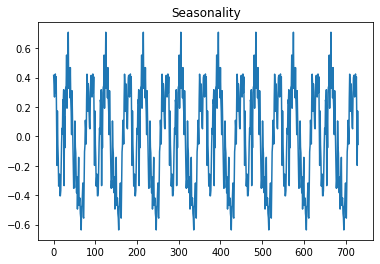

In [16]:
plt.title('Seasonality')
decomp.seasonal.plot()

The plot above shows the presence of seasonality in the data.

•   Trend

<AxesSubplot:title={'center':'Trend'}>

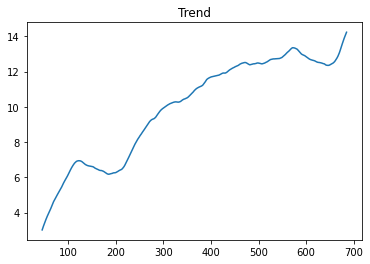

In [17]:
plt.title('Trend')
decomp.trend.plot()

We can see there is a trending increase in the revenue.

•   Residuals

<AxesSubplot:title={'center':'Residuals'}>

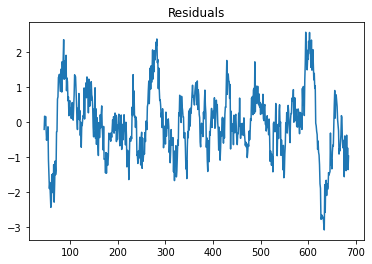

In [18]:
plt.title('Residuals')
decomp.resid.plot()

Residuals are random and they are oscilating around 0 which meand that the mean is close to 0.

•   Auto correlation function or ACF

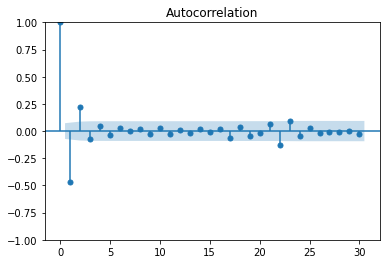

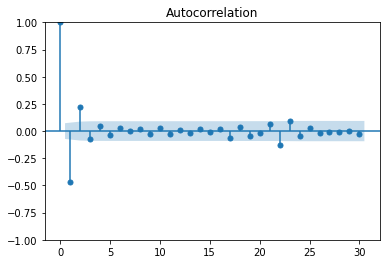

In [19]:
plot_acf(diff, lags=30)

The ACF plot shows that there are 2 lags that are significantly correlated with the first lag, this means that q=2.

•   Partial auto correlation function or PACF

c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


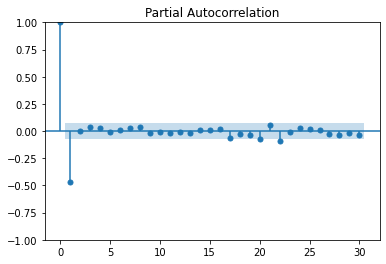

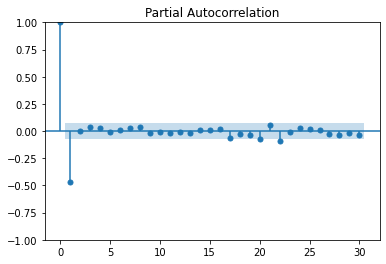

In [20]:
plot_pacf(diff, lags=30)

In the case of PACF, there is only one lag that correlates significantly to the first one, which means that we will be using p=1.

•   Spectral density

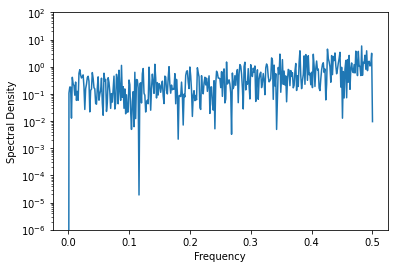

In [21]:
f, Pxx_den = signal.periodogram(diff)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()


With the spectral density, we are looking at the time series as a function of frequency. The plot above tells us that the frequency happens randomly, i.e, the time series is cyclical.

•   Decomposed time series

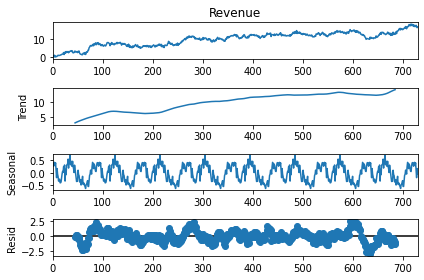

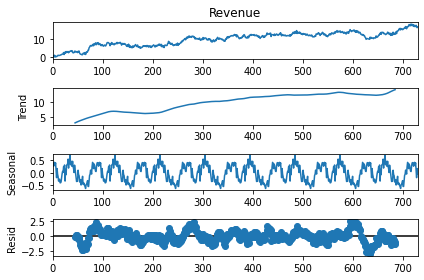

In [23]:
decomp.plot()

D2. ARIMA model

We will run the model with the values calculated above.

In [24]:
model = ARIMA(X_train, order=(1,1,2))
model = model.fit()
model.summary()

c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\paowm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  547
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -365.878
Date:                Sun, 14 May 2023   AIC                            739.757
Time:                        00:40:05   BIC                            756.967
Sample:                             0   HQIC                           746.485
                                - 547                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4773      0.078     -6.097      0.000      -0.631      -0.324
ma.L1         -0.9862      0.405     -2.437      0.015      -1.779      -0.193
ma.L2         -0.0137      0.089     -0.154      0.878      -0.188       0.161
sigma2         0.2207      0.088      2.494      0.013       0.047       0.394
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.92   Prob(JB):                         0.51
Heteroskedasticity (H):               1.01   Skew:                            -0.06
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Since we want to find the best model for the time series, we will run the auto_arima function which will choose the best model based on the AIC score. We will add the parameters

In [67]:
arima = auto_arima(X_train,trace=True, suppress_warnings=True, test='adf', start_p=1, start_q=1, d=1, max_p=3, max_q=3, max_d=2)
arima.fit(X_train)
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1448.911, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1026.745, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1446.913, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=902.285, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=863.859, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=861.878, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=900.300, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 3.990 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  547
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -426.939
Date:                Sun, 14 May 2023   AIC                            861.878
Time:                        01:40:14   BIC                            879.088
Sample:                             0   HQIC                           868.606
                                - 547                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1927      0.041    -29.192      0.000      -1.273      -1.113
ar.L2         -0.7418      0.057    -12.953      0.000      -0.854      -0.630
ar.L3         -0.2678      0.042     -6.303      0.000      -0.351      -0.185
sigma2         0.2790      0.018     15.255      0.000       0.243       0.315
===================================================================================
Ljung-Box (L1) (Q):                   1.58   Jarque-Bera (JB):                 3.98
Prob(Q):                              0.21   Prob(JB):                         0.14
Heteroskedasticity (H):               1.04   Skew:                            -0.15
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the results above, the best ARIMA model for the time series would be when p=3, d=1, and q=0. This model has the lowest AIC which is a score used to evaluate how good a model fits the data. 

We will run the SARIMAX model with our training set for forecasting.

In [82]:
model = SARIMAX(df['Revenue'], order=(3,1,0),seasonal_order=(3,1,0,90), method='innovations_mle')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  731
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 90)   Log Likelihood                -524.677
Date:                            Sun, 14 May 2023   AIC                           1063.354
Time:                                    02:09:19   BIC                           1094.584
Sample:                                         0   HQIC                          1075.476
                                            - 731                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4826      0.040    -11.957      0.000      -0.562      -0.404
ar.L2          0.0156      0.044      0.357      0.721      -0.070       0.102
ar.L3          0.0541      0.040      1.339      0.181      -0.025       0.133
ar.S.L90      -0.6736      0.044    -15.207      0.000      -0.760      -0.587
ar.S.L180     -0.4346      0.054     -8.070      0.000      -0.540      -0.329
ar.S.L270     -0.2146      0.054     -4.010      0.000      -0.320      -0.110
sigma2         0.2779      0.017     16.287      0.000       0.244       0.311
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.90   Prob(JB):                         0.66
Heteroskedasticity (H):               1.13   Skew:                            -0.08
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

D3. Forecasting using ARIMA model

In [83]:
df['Forecast']=results.predict(start=547,end=731,dynamic=True)
df['Forecast'].iloc[-183:]

548    11.623032
549    12.369972
550    12.144649
551    11.888477
552    11.744833
         ...    
726    14.480861
727    14.227387
728    13.462763
729    14.262566
730    14.044421
Name: Forecast, Length: 183, dtype: float64

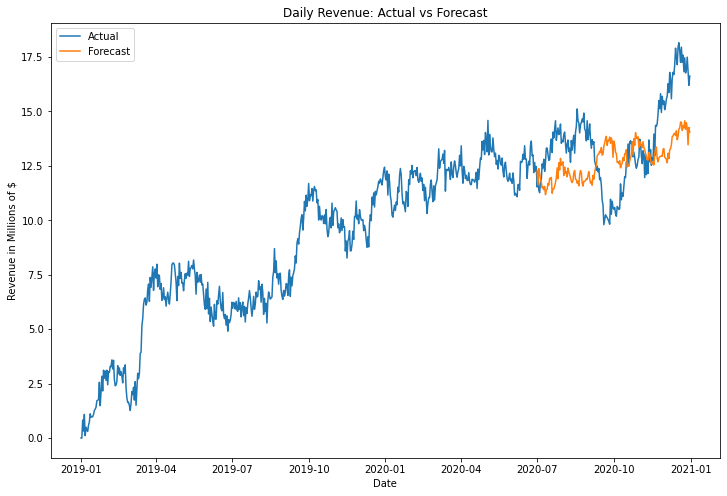

In [84]:
x1=df['Date']
y1=df['Revenue']
y2=df['Forecast']
x2=df['Date']

plt.figure(figsize=(12,8))
plt.plot(x1,y1, label='Actual')
plt.plot(x2,y2, label='Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue in Millions of $')
plt.title('Daily Revenue: Actual vs Forecast')
plt.show()

D4. Output and calculations

D5. Code

E1. Results

The selectiom of ARIMA model:

The ARIMA model selected was the SARIMAX as indicated by the results gotten from the auto_arima iteration. The best model includes the values of p,d,q as 3,1,0 respectively. 

Prediction interval of the forecast:

The prediction interval is 1 day since the time series consists of daily revenue. 

Justification  of the forecast length:

The forecast will be for 183 days which is about 6 months of daily revenue since our time series contains daily revenue for 2 years (731 days). 

Model evaluation procedure and error metric:

As the evaluation procedure, we used the AIC to select the optimal order for the model when performing the auto arima. The lower the AIC score the better the model is. In this case the best model had a AIC score of 731. 

For the error metric we are using RMSE (Root mean square error) which is the standard deviation of the residuals, i.e, a measure of how spread out the residuals are.

In [86]:
rmse = sqrt(mean_squared_error(df['Forecast'].iloc[-183:], df['Revenue'].iloc[-183:]))
rmse

2.1032667171738586

The RMSE for our model is larger than 0 which indicates that the model is not very accurate at predicting future values.

E2. Annotated visualization

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-26',
               '2021-06-27', '2021-06-28', '2021-06-29', '2021-06-30',
               '2021-07-01', '2021-07-02'],
              dtype='datetime64[ns]', length=184, freq='D')
2020-12-31    16.494644
2021-01-01    16.586656
2021-01-02    17.106266
2021-01-03    17.016518
2021-01-04    17.146204
                ...    
2021-06-28    23.638569
2021-06-29    23.475476
2021-06-30    23.513700
2021-07-01    24.015747
2021-07-02    23.936042
Freq: D, Name: predicted_mean, Length: 184, dtype: float64


<AxesSubplot:title={'center':'Daily Revenue: Forecast 2021'}, xlabel='Date', ylabel='Revenue in Millions of $'>

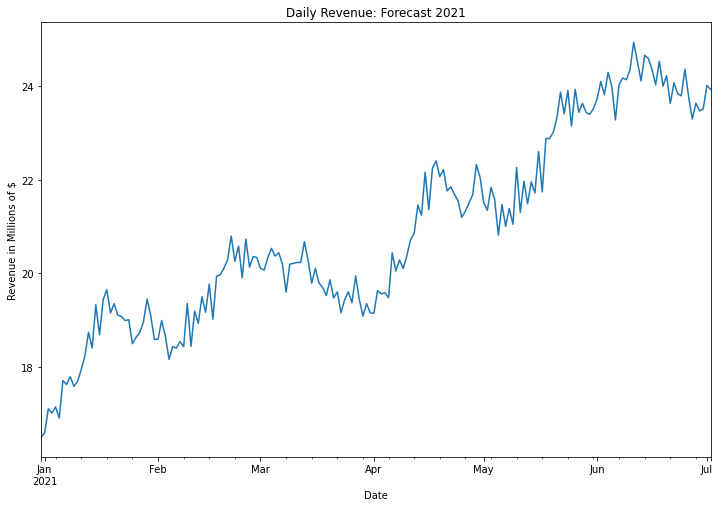

In [79]:
index_future = pd.date_range(start='2020-12-31', end='2021-07-02')
print(index_future)
pred = results.predict(start=len(df), end=len(df)+183, type='levels')
pred.index=index_future
print(pred)

pred.plot(figsize=(12,8), xlabel='Date',ylabel='Revenue in Millions of $', title='Daily Revenue: Forecast 2021')


E3. Course of action

Our forecast shows a trending increase in the revenue for 2021 surpassing the $24M between June and July. If the company keeps working towards keeping current customers and gaining new ones, the revenue could be close to the amount showed in the plot.

F. Jupyter notebook as part of the submission

G. Third-party code

Datacamp. (n.d.). Retrieved from https://campus.datacamp.com/courses/arima-models-in-python 

Justin, L. &. (n.d.). Retrieved from https://github.com/liannewriting/YouTube-videos-public/blob/main/arima-model-time-series-prediction-python/time-series-arima.ipynb

Naik, K. (n.d.). Retrieved from https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/blob/master/Untitled.ipynb

H. Sources

Gunjal, S. (2021). Retrieved from https://www.kaggle.com/general/215997

Justin, L. &. (2022, August 25). Retrieved from How to build ARIMA models in Python for time series prediction: https://www.justintodata.com/arima-models-in-python-time-series-prediction/

Zajic, A. (2022, November 29). Retrieved from https://builtin.com/data-science/what-is-aic